In [127]:
!pip install numpy pandas keras seaborn matplotlib pandas_profiling factor_analyzer sklearn tensorflow mglearn

In [128]:
import numpy as np 
import pandas as pd
import keras
import seaborn as sns
import matplotlib
import warnings

%matplotlib inline

from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from sklearn import preprocessing
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error, median_absolute_error, r2_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import mglearn

from tensorflow.keras import layers

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.style.use(['dark_background'])

df_raw = pd.read_csv('SpotifyFeatures.csv')

In [129]:
# Columnas del dataset
df_raw.keys()

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

## Tipos de variables

| **Variable**      | **Tipo**   |
|-------------------|------------|
| `genre`           | Categórica |
| `artist_name`     | Categórica |
| `track_name`      | Categórica |
| `track_id`        | Primaria   |
| `popularity`      | Numérica   |
| `acousticness`    | Numérica   |
| `danceability`    | Numérica   |
| `duration_ms`     | Numérica   |
| `energy`          | Numérica   |
| `instrumentalness`| Numérica   |
| `key`             | Categórica |
| `liveness`        | Numérica   |
| `loudness`        | Numérica   |
| `mode`            | Categórica |
| `speechiness`     | Numérica   |
| `tempo`           | Numérica   |
| `time_signature`  | Categórica |
| `valence`         | Numérica   |

Se usarán las variables duration_ms, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, valence, tempo, time_signature

La variable objetivo es popularity

* `popularity`: escala del 1 al 100 que representa la popularidad de la canción en Spotify 
* `genre`: nombre del género musical correspondiente a la pista, de acuerdo al autor del dataset hay 26 géneros distintos
* `duration_ms`: duración en milisegundos de la canción
* `danceability`: qué tan bailable es una canción, en una escala del 0.0 al 1.0
* `energy`: qué tan energética es una canción, en una escela del 0.0 al 1.0
* `key`: tono de la canción (https://es.wikipedia.org/wiki/Clases_de_tonos)
* `loudness`: qué tan ruidosa es una canción, en decibeles (dB)
* `mode`: indica si la modalidad de la canción es mayor (1) o menor (0)
* `speechiness`: qué tantas palabras 'habladas' están presentes en la pista, en una escala del 0.0 al 1.0
* `acousticness`: qué tan acústica es una canción, en una escala del 0.0 al 1.0
* `instrumentalness`: qué tan instrumental es la canción, en una escala del 0.0 al 1.0
* `valence`: qué tan positiva o animada es una canción, en una escala del 0.0 al 1.0
* `tempo`: el tempo de la canción en BPM
* `time_signature`: qué tantos tiempos hay en cada compás (https://es.wikipedia.org/wiki/Comp%C3%A1s_(m%C3%BAsica))

https://developer.spotify.com/documentation/web-api/reference/#object-audiofeaturesobject

Se describen a continuación las columnas omitidas. La mayoría de estas fueron descartadas debido a que el objetivo de este proyecto es relacionar las características propias musicales de una canción con su popularidad, factores externos como el artista o el año de publicación se escapan del alcance

* `artist_name`: nombre del artista
* `track_name`: nombre de la canción
* `track_id`: ID de la canción
* `liveness`: indicador en escala del 0.0 al 1.0 de qué tan 'en vivo' es una canción


# EDA



## Datos erróneos

Se revisa si existen registros fuera de rango (potenciales errores)

In [130]:
df_raw.describe()

popularity   acousticness   danceability   duration_ms  \
count  232725.000000  232725.000000  232725.000000  2.327250e+05   
mean       41.127502       0.368560       0.554364  2.351223e+05   
std        18.189948       0.354768       0.185608  1.189359e+05   
min         0.000000       0.000000       0.056900  1.538700e+04   
25%        29.000000       0.037600       0.435000  1.828570e+05   
50%        43.000000       0.232000       0.571000  2.204270e+05   
75%        55.000000       0.722000       0.692000  2.657680e+05   
max       100.000000       0.996000       0.989000  5.552917e+06   

              energy  instrumentalness       liveness       loudness  \
count  232725.000000     232725.000000  232725.000000  232725.000000   
mean        0.570958          0.148301       0.215009      -9.569885   
std         0.263456          0.302768       0.198273       5.998204   
min         0.000020          0.000000       0.009670     -52.457000   
25%         0.385000          0.000000       0.097400     -11.771000   
50%         0.605000          0.000044       0.128000      -7.762000   
75%         0.787000          0.035800       0.264000      -5.501000   
max         0.999000          0.999000       1.000000       3.744000   

         speechiness          tempo        valence  
count  232725.000000  232725.000000  232725.000000  
mean        0.120765     117.666585       0.454917  
std         0.185518      30.898907       0.260065  
min         0.022200      30.379000       0.000000  
25%         0.036700      92.959000       0.237000  
50%         0.050100     115.778000       0.444000  
75%         0.105000     139.054000       0.660000  
max         0.967000     242.903000       1.000000

De acuerdo con las descripciones de las variables, obtenidas de la documentación de la API de Spotify, ninguna variable presenta valores máximos o mínimos fuera de lo esperable.

## Datos perdidos
Se revisa si existen registros nulos que correspondan a valores perdidos

In [131]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

No hay pérdida de datos

In [132]:
pd.isnull(df_raw).sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [133]:
df_raw.corr()

popularity  acousticness  danceability  duration_ms  \
popularity          1.000000     -0.381295      0.256564     0.002348   
acousticness       -0.381295      1.000000     -0.364546     0.011203   
danceability        0.256564     -0.364546      1.000000    -0.125781   
duration_ms         0.002348      0.011203     -0.125781     1.000000   
energy              0.248922     -0.725576      0.325807    -0.030550   
instrumentalness   -0.210983      0.316154     -0.364941     0.076021   
liveness           -0.167995      0.069004     -0.041684     0.023783   
loudness            0.363011     -0.690202      0.438668    -0.047618   
speechiness        -0.151076      0.150935      0.134560    -0.016171   
tempo               0.081039     -0.238247      0.021939    -0.028456   
valence             0.060076     -0.325798      0.547154    -0.141811   

                    energy  instrumentalness  liveness  loudness  speechiness  \
popularity        0.248922         -0.210983 -0.167995  0.363011    -0.151076   
acousticness     -0.725576          0.316154  0.069004 -0.690202     0.150935   
danceability      0.325807         -0.364941 -0.041684  0.438668     0.134560   
duration_ms      -0.030550          0.076021  0.023783 -0.047618    -0.016171   
energy            1.000000         -0.378957  0.192801  0.816088     0.145120   
instrumentalness -0.378957          1.000000 -0.134198 -0.506320    -0.177147   
liveness          0.192801         -0.134198  1.000000  0.045686     0.510147   
loudness          0.816088         -0.506320  0.045686  1.000000    -0.002273   
speechiness       0.145120         -0.177147  0.510147 -0.002273     1.000000   
tempo             0.228774         -0.104133 -0.051355  0.228364    -0.081541   
valence           0.436771         -0.307522  0.011804  0.399901     0.023842   

                     tempo   valence  
popularity        0.081039  0.060076  
acousticness     -0.238247 -0.325798  
danceability      0.021939  0.547154  
duration_ms      -0.028456 -0.141811  
energy            0.228774  0.436771  
instrumentalness -0.104133 -0.307522  
liveness         -0.051355  0.011804  
loudness          0.228364  0.399901  
speechiness      -0.081541  0.023842  
tempo             1.000000  0.134857  
valence           0.134857  1.000000

<AxesSubplot:>

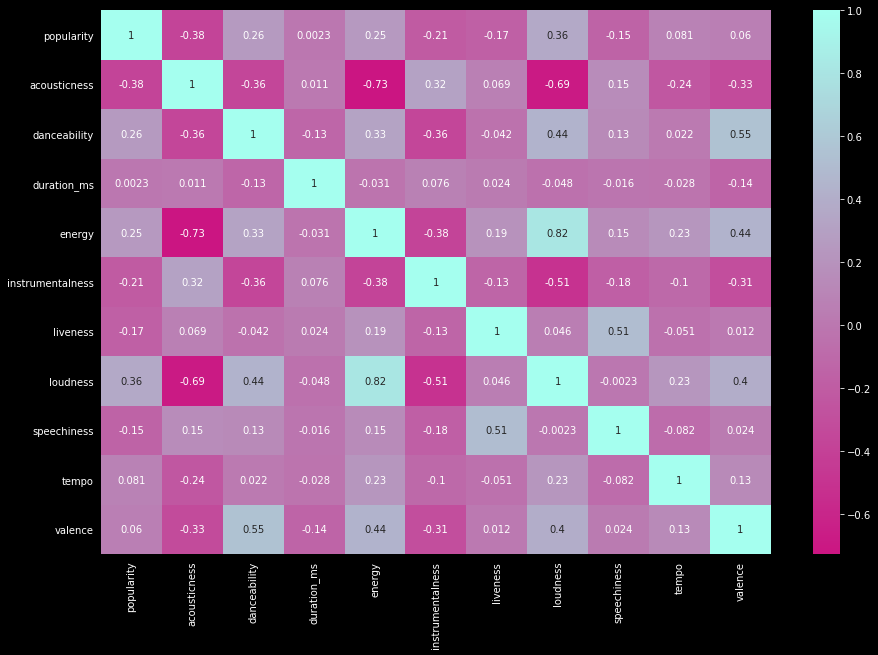

In [134]:
# Correlación de Pearson
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

r = df_raw.corr(method='pearson')
hc = ['#CB1582', '#A5FFEF']
th = [0, 1]
cdict = NonLinCdict(th, hc)
cm = matplotlib.colors.LinearSegmentedColormap('test', cdict)
plt.figure(figsize = (15,10))
sns.heatmap(r,
            xticklabels=r.columns,
            yticklabels=r.columns,
            cmap=cm,
            annot=True)

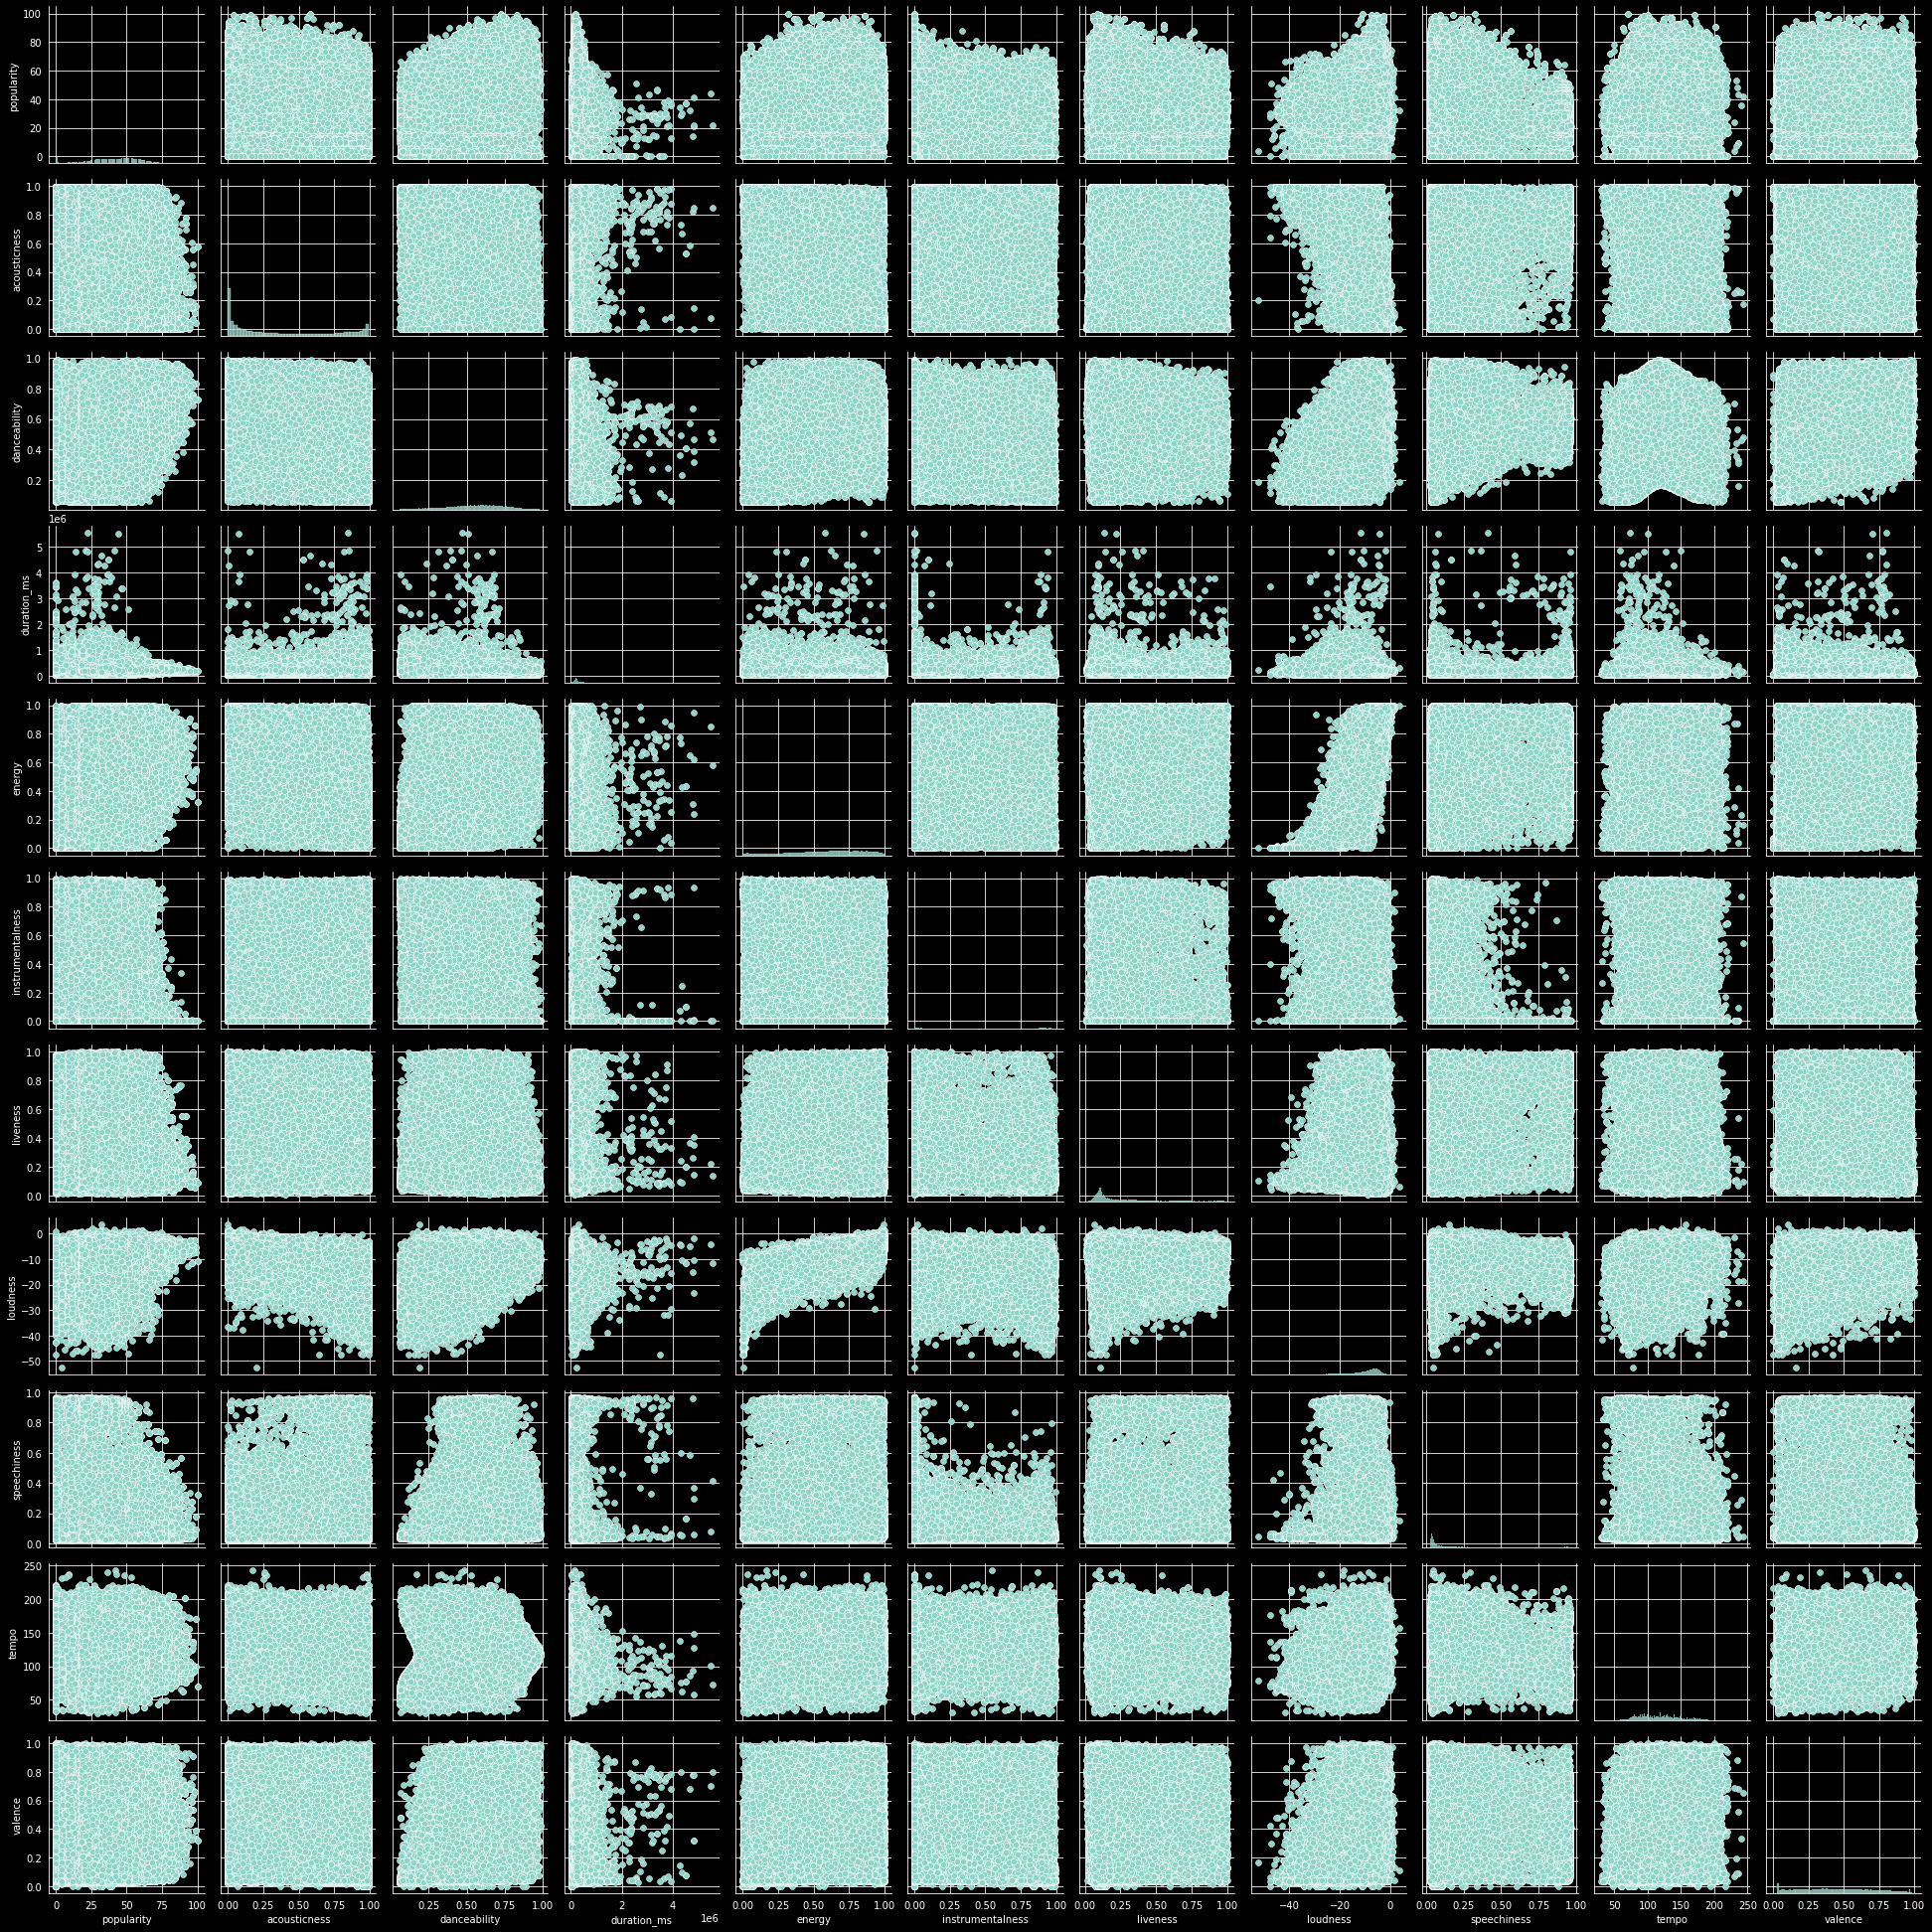

In [135]:
sns.pairplot(df_raw)

## Outliers

In [136]:
Q1 = df_raw.quantile(0.25)
Q3 = df_raw.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

popularity             26.0000
acousticness            0.6844
danceability            0.2570
duration_ms         82911.0000
energy                  0.4020
instrumentalness        0.0358
liveness                0.1666
loudness                6.2700
speechiness             0.0683
tempo                  46.0950
valence                 0.4230
dtype: float64


In [137]:
(Q1 - 1.5 * IQR)

popularity            -10.00000
acousticness           -0.98900
danceability            0.04950
duration_ms         58490.50000
energy                 -0.21800
instrumentalness       -0.05370
liveness               -0.15250
loudness              -21.17600
speechiness            -0.06575
tempo                  23.81650
valence                -0.39750
dtype: float64

In [138]:
(Q3 + 1.5 * IQR)

popularity              94.00000
acousticness             1.74860
danceability             1.07750
duration_ms         390134.50000
energy                   1.39000
instrumentalness         0.08950
liveness                 0.51390
loudness                 3.90400
speechiness              0.20745
tempo                  208.19650
valence                  1.29450
dtype: float64

### `popularity`

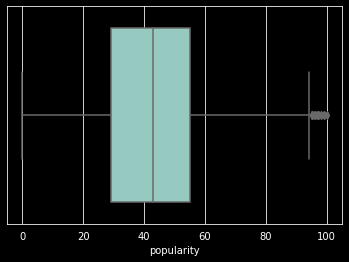

In [139]:
ax = sns.boxplot(x=df_raw['popularity'])

Esta columna presenta valores marginales mayores a `90`.

In [140]:
df_raw[df_raw.popularity > 90].sort_values(by = 'popularity', ascending = False)

genre             artist_name  \
107804    Pop           Ariana Grande   
9027    Dance           Ariana Grande   
9026    Dance           Ariana Grande   
86951     Rap             Post Malone   
107803    Pop             Post Malone   
...       ...                     ...   
107826    Pop                 Cardi B   
86962     Rap  A Boogie Wit da Hoodie   
9030    Dance           Ariana Grande   
86960     Rap              Juice WRLD   
9032    Dance           Ariana Grande   

                                      track_name                track_id  \
107804                                   7 rings  14msK75pk3pA33pzPVNtBF   
9027                                     7 rings  14msK75pk3pA33pzPVNtBF   
9026    break up with your girlfriend, i'm bored  4kV4N9D1iKVxx1KLvtTpjS   
86951                                       Wow.  6MWtB6iiXyIwun0YzU6DFP   
107803                                      Wow.  6MWtB6iiXyIwun0YzU6DFP   
...                                          ...                     ...   
107826                                 Please Me  0PG9fbaaHFHfre2gUVo7AN   
86962                    Swervin (feat. 6ix9ine)  1wJRveJZLSb1rjhnUHQiv6   
9030                                        NASA  4uTvPEr01pjTbZgl7jcKBD   
86960                                    Robbery  44ShclXTOOnYtt5CnCDeGV   
9032                                   bloodline  2hloaUoRonYssMuqLCBLTX   

        popularity  acousticness  danceability  duration_ms  energy  \
107804         100        0.5780         0.725       178640   0.321   
9027           100        0.5780         0.725       178640   0.321   
9026            99        0.0421         0.726       190440   0.554   
86951           99        0.1630         0.833       149520   0.539   
107803          99        0.1630         0.833       149520   0.539   
...            ...           ...           ...          ...     ...   
107826          91        0.0642         0.747       200890   0.570   
86962           91        0.0153         0.581       189487   0.662   
9030            91        0.4510         0.747       182000   0.458   
86960           91        0.3420         0.708       240527   0.691   
9032            91        0.0815         0.758       216893   0.665   

        instrumentalness key  liveness  loudness   mode  speechiness    tempo  \
107804          0.000000  C#    0.0884   -10.744  Minor       0.3230   70.142   
9027            0.000000  C#    0.0884   -10.744  Minor       0.3230   70.142   
9026            0.000000   F    0.1060    -5.290  Minor       0.0917  169.999   
86951           0.000002   B    0.1010    -7.399  Minor       0.1780   99.947   
107803          0.000002   B    0.1010    -7.399  Minor       0.1780   99.947   
...                  ...  ..       ...       ...    ...          ...      ...   
107826          0.000000  C#    0.0832    -6.711  Major       0.0810  133.992   
86962           0.000000   A    0.1110    -5.239  Major       0.3030   93.023   
9030            0.000000  F#    0.2520    -6.891  Major       0.3030   75.029   
86960           0.000000   D    0.2220    -5.179  Major       0.0442   79.990   
9032            0.000157   D    0.2160    -5.188  Minor       0.0774  151.976   

       time_signature  valence  
107804            4/4    0.319  
9027              4/4    0.319  
9026              4/4    0.335  
86951             4/4    0.385  
107803            4/4    0.385  
...               ...      ...  
107826            4/4    0.650  
86962             4/4    0.434  
9030              4/4    0.470  
86960             4/4    0.535  
9032              4/4    0.643  

[107 rows x 18 columns]

Dado que se trata de pistas que claramente gozan de gran popularidad, se opta por conservar estos outliers

### `genre`

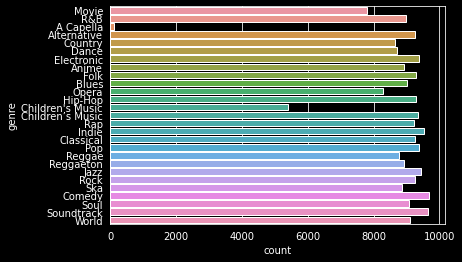

In [141]:
sns.countplot(y='genre', data=df_raw)
plt.show()

### `duration_ms`

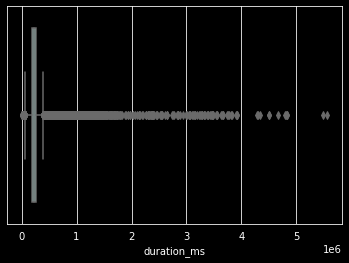

In [142]:
ax = sns.boxplot(x=df_raw['duration_ms'])

### `danceability`

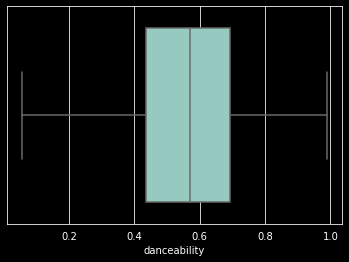

In [143]:
ax = sns.boxplot(x=df_raw['danceability'])

### `energy`

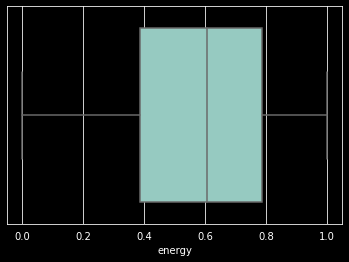

In [144]:
ax = sns.boxplot(x=df_raw['energy'])

### `key`

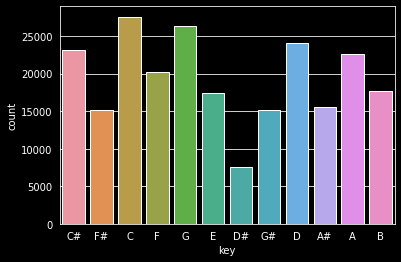

In [145]:
sns.countplot(x='key', data=df_raw)
plt.show()

### `loudness`

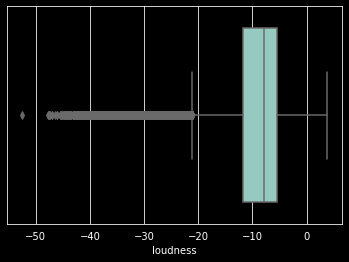

In [146]:
ax = sns.boxplot(x=df_raw['loudness'])

Existen valores marginales por debajo de los `-20` decibeles

In [147]:
df_raw[df_raw.loudness < -20].sort_values(by = 'loudness', ascending = False)

genre             artist_name  \
198851  Soundtrack        Dario Marianelli   
106476       Opera  Philharmonia Orchestra   
81730        Opera        Vincenzo Righini   
125574   Classical   Johann Sebastian Bach   
58715        Opera     Jean-Baptiste Lully   
...            ...                     ...   
126602   Classical     Sergei Rachmaninoff   
203063  Soundtrack           Thomas Newman   
126046   Classical          Hector Berlioz   
218540       World               Brian Eno   
218717       World       Shakuhachi Sakano   

                                               track_name  \
198851                                     Wandering Jane   
106476                                     Attempted Rape   
81730   Il natal d'Apollo: Ove son? Qual'aure io spiro...   
125574  Suite For Cello Solo No.1 In G Major, BWV 1007...   
58715   Le bourgeois gentilhomme, LWV 43: Marche pour ...   
...                                                   ...   
126602  Variations On A Theme Of Chopin, Op.22: Variat...   
203063                               Limes - Instrumental   
126046  La Damnation de Faust, Op. 24, H. 111: Pt. II,...   
218540                                             Neroli   
218717                                       Call to Wake   

                      track_id  popularity  acousticness  danceability  \
198851  36SQrVxIeTBayrrFFyFTaB          45         0.867        0.0832   
106476  6FTnToDvYTJbMgXLmZRfCP           2         0.890        0.2840   
81730   3qKoMwNqBiCgo49SLt3rcB          11         0.980        0.3370   
125574  33nGOxKRELz4QevlsTOAdk          38         0.989        0.3740   
58715   0bwFMmBFZIlmqM56jEJNnR          24         0.662        0.4090   
...                        ...         ...           ...           ...   
126602  5qXvC0LU7KxQOnZeBvox5D          29         0.993        0.1840   
203063  5KdaDmHLNxbS81Rgg7eIyY          27         0.642        0.2210   
126046  66WEzRFci7C81y3wnkUXew           0         0.794        0.1550   
218540  6oW8CEEQjzVVC1ddFVnUUe          30         0.953        0.1200   
218717  0i0qFr5IN1TZBE5venBUUk           4         0.203        0.1870   

        duration_ms    energy  instrumentalness key  liveness  loudness  \
198851       181973  0.185000          0.770000  A#    0.5860   -20.001   
106476       105707  0.189000          0.960000   G    0.3950   -20.001   
81730        429547  0.105000          0.000025  A#    0.1030   -20.001   
125574       149360  0.142000          0.877000   G    0.1420   -20.001   
58715         75987  0.050400          0.000025  F#    0.2850   -20.001   
...             ...       ...               ...  ..       ...       ...   
126602        83093  0.001880          0.950000  C#    0.0629   -47.432   
203063        35493  0.000263          0.402000  C#    0.1090   -47.499   
126046       154560  0.001700          0.000882   D    0.0712   -47.599   
218540      3476293  0.001230          0.921000   D    0.1470   -47.669   
218717       231000  0.000970          0.000220   C    0.1040   -52.457   

         mode  speechiness    tempo time_signature  valence  
198851  Major       0.0445  171.718            3/4   0.0358  
106476  Minor       0.0410   84.693            4/4   0.0557  
81730   Major       0.0489  105.646            4/4   0.0627  
125574  Major       0.0421   83.976            4/4   0.5600  
58715   Minor       0.0578   74.042            3/4   0.2620  
...       ...          ...      ...            ...      ...  
126602  Major       0.0460  176.782            4/4   0.4230  
203063  Major       0.0649   72.101            4/4   0.0000  
126046  Major       0.0462  135.659            3/4   0.0603  
218540  Minor       0.0438   70.389            3/4   0.0345  
218717  Major       0.0439   78.358            4/4   0.1640  

[17057 rows x 18 columns]

### `mode`

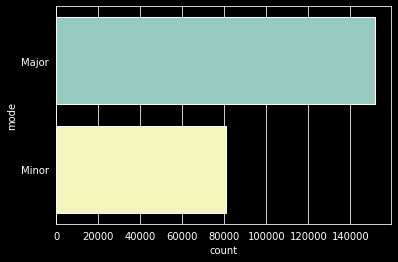

In [148]:
sns.countplot(y='mode', data=df_raw)
plt.show()

### `speechiness`

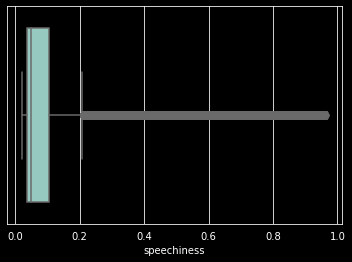

In [149]:
ax = sns.boxplot(x=df_raw['speechiness'])

### `acousticness`

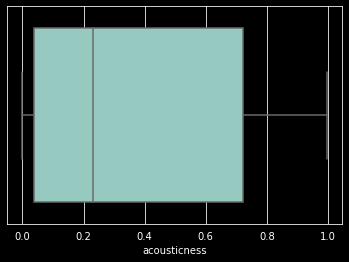

In [150]:
ax = sns.boxplot(x=df_raw['acousticness'])

### `instrumentalness`

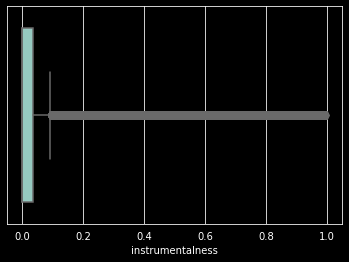

In [151]:
ax = sns.boxplot(x=df_raw['instrumentalness'])

### `valence`

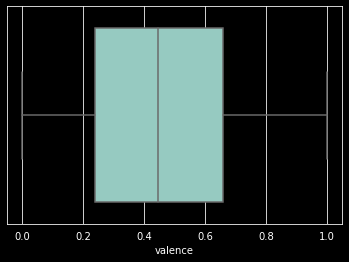

In [152]:
ax = sns.boxplot(x=df_raw['valence'])

### `tempo`

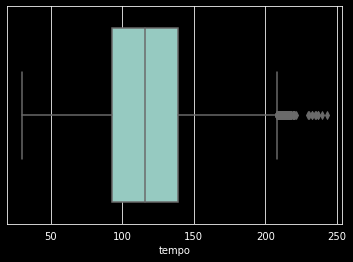

In [153]:
ax = sns.boxplot(x=df_raw['tempo'])

    Se observan valores marginales por sobre los `200` bpm

In [154]:
df_raw[df_raw.tempo > 200].sort_values(by = 'tempo', ascending = False)

genre     artist_name                     track_name  \
48149         Blues       J.J. Cale                Call The Doctor   
178918         Jazz          B-Side                            Sky   
66153          Folk   Grateful Dead       Candyman - 2013 Remaster   
82435         Opera  Giuseppe Verdi             Aida: Immenso Fthà   
82586         Opera  Giuseppe Verdi         Aida: Ah no! fuggiamo!   
...             ...             ...                            ...   
9463    Alternative          Masego       African Lady - ADM Remix   
55938         Movie        Dorothée  Les Filles Aiment Les Garçons   
13315   Alternative  As I Lay Dying                      Parallels   
130653    Classical     DragonForce                        No More   
32565         Anime          Utsu-P                      般若心経ハードコア   

                      track_id  popularity  acousticness  danceability  \
48149   55ROr3cl3yi4YRBgfpDy1d          42      0.174000         0.482   
178918  5pA8zdnj8fWHzJMReuhmSq          36      0.260000         0.461   
66153   4FJ0051ukEptZAhP01ExGV          43      0.261000         0.332   
82435   62bPVBwMmCEvKQZGgDxk6H           9      0.977000         0.166   
82586   0bwcpWRtpDm4Lt3hC2dj9R           9      0.975000         0.311   
...                        ...         ...           ...           ...   
9463    0JcR9JMMgKb0J7EjXvZlLj          48      0.008200         0.617   
55938   1ujd7DPB3HpPo7cEZEP7W7           2      0.150000         0.685   
13315   50mHTNxev0bSYQhuAASe17          46      0.000006         0.282   
130653  1Aj5ohhvjReUo02kiTsi3B          24      0.000019         0.309   
32565   6tD6kBS0GgVjv50GiFc1Ww          19      0.006920         0.446   

        duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
48149        148333  0.1660          0.546000  C#    0.0979   -18.522  Minor   
178918       201023  0.2310          0.872000   A    0.2180    -8.386  Major   
66153        373970  0.4230          0.000140   C    0.0716   -12.102  Major   
82435         45733  0.0357          0.001250  C#    0.1820   -27.304  Major   
82586         32333  0.1710          0.096500   F    0.5400   -18.601  Major   
...             ...     ...               ...  ..       ...       ...    ...   
9463         229606  0.8420          0.000743   E    0.1080    -7.124  Minor   
55938        171389  0.6570          0.000000   A    0.0625    -9.871  Major   
13315        297427  0.9700          0.358000   G    0.3850    -4.086  Major   
130653       230133  0.9660          0.000003  C#    0.3260    -3.838  Minor   
32565        108916  0.9930          0.173000  F#    0.0776    -3.264  Major   

        speechiness    tempo time_signature  valence  
48149        0.0465  242.903            3/4   0.6530  
178918       0.2890  239.848            3/4   0.3320  
66153        0.0384  236.799            3/4   0.5190  
82435        0.0507  236.735            3/4   0.0903  
82586        0.1030  235.446            3/4   0.6790  
...             ...      ...            ...      ...  
9463         0.1290  200.005            4/4   0.2540  
55938        0.0524  200.005            4/4   0.9410  
13315        0.1800  200.005            4/4   0.0391  
130653       0.1300  200.002            4/4   0.3340  
32565        0.2450  200.002            4/4   0.4320  

[1101 rows x 18 columns]

### `time_signature`

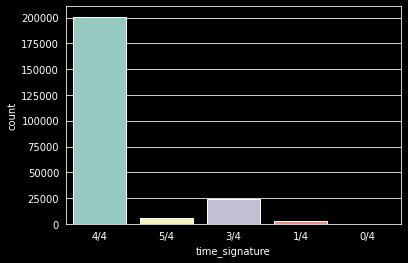

In [155]:
sns.countplot(x='time_signature', data=df_raw)
plt.show()

# Tratamiento de datos

In [156]:
# Se crea copia del dataframe original 

df = df_raw.copy()

In [157]:
# Se eliminan las columnas que no se utilizarán

df.drop(['artist_name', 'track_name', 'track_id', 'liveness'], axis = 1, inplace = True)

In [158]:
df.head()

genre  popularity  acousticness  danceability  duration_ms  energy  \
0  Movie           0         0.611         0.389        99373   0.910   
1  Movie           1         0.246         0.590       137373   0.737   
2  Movie           3         0.952         0.663       170267   0.131   
3  Movie           0         0.703         0.240       152427   0.326   
4  Movie           4         0.950         0.331        82625   0.225   

   instrumentalness key  loudness   mode  speechiness    tempo time_signature  \
0             0.000  C#    -1.828  Major       0.0525  166.969            4/4   
1             0.000  F#    -5.559  Minor       0.0868  174.003            4/4   
2             0.000   C   -13.879  Minor       0.0362   99.488            5/4   
3             0.000  C#   -12.178  Major       0.0395  171.758            4/4   
4             0.123   F   -21.150  Major       0.0456  140.576            4/4   

   valence  
0    0.814  
1    0.816  
2    0.368  
3    0.227  
4    0.390

In [159]:
genre_range = list({_ for _ in df['genre']})
genre_range = list(map(str.lower, genre_range))
time_range = list({_ for _ in df['time_signature']})
time_range = list(map(str.lower, time_range))

In [160]:
keys = pd.get_dummies(df['key'])
keys.columns = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

modes = pd.get_dummies(df['mode'])
modes.columns = ['minor', 'major']

# Esto añade 20+ columnas al dataframe así que lo omitiré por ahora
# genres = pd.get_dummies(df['genre'])
# genres.columns = genre_range

times = pd.get_dummies(df['time_signature'])
times.columns = time_range

df.drop(['key', 'mode', 'time_signature', 'genre'], axis = 1, inplace = True)

frames = [df, keys, modes, times]
df = pd.concat(frames, axis = 1)
df.head()

popularity  acousticness  danceability  duration_ms  energy  \
0           0         0.611         0.389        99373   0.910   
1           1         0.246         0.590       137373   0.737   
2           3         0.952         0.663       170267   0.131   
3           0         0.703         0.240       152427   0.326   
4           4         0.950         0.331        82625   0.225   

   instrumentalness  loudness  speechiness    tempo  valence  ...  A  A#  B  \
0             0.000    -1.828       0.0525  166.969    0.814  ...  0   0  0   
1             0.000    -5.559       0.0868  174.003    0.816  ...  1   0  0   
2             0.000   -13.879       0.0362   99.488    0.368  ...  0   0  0   
3             0.000   -12.178       0.0395  171.758    0.227  ...  0   0  0   
4             0.123   -21.150       0.0456  140.576    0.390  ...  0   0  0   

   minor  major  4/4  0/4  5/4  1/4  3/4  
0      1      0    0    0    0    1    0  
1      0      1    0    0    0    1    0  
2      0      1    0    0    0    0    1  
3      1      0    0    0    0    1    0  
4      1      0    0    0    0    1    0  

[5 rows x 29 columns]

In [161]:
df.isna().sum()

popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
loudness            0
speechiness         0
tempo               0
valence             0
C                   0
C#                  0
D                   0
D#                  0
E                   0
F                   0
F#                  0
G                   0
G#                  0
A                   0
A#                  0
B                   0
minor               0
major               0
4/4                 0
0/4                 0
5/4                 0
1/4                 0
3/4                 0
dtype: int64

# Análisis de factores

In [162]:
df.describe()

popularity   acousticness   danceability   duration_ms  \
count  232725.000000  232725.000000  232725.000000  2.327250e+05   
mean       41.127502       0.368560       0.554364  2.351223e+05   
std        18.189948       0.354768       0.185608  1.189359e+05   
min         0.000000       0.000000       0.056900  1.538700e+04   
25%        29.000000       0.037600       0.435000  1.828570e+05   
50%        43.000000       0.232000       0.571000  2.204270e+05   
75%        55.000000       0.722000       0.692000  2.657680e+05   
max       100.000000       0.996000       0.989000  5.552917e+06   

              energy  instrumentalness       loudness    speechiness  \
count  232725.000000     232725.000000  232725.000000  232725.000000   
mean        0.570958          0.148301      -9.569885       0.120765   
std         0.263456          0.302768       5.998204       0.185518   
min         0.000020          0.000000     -52.457000       0.022200   
25%         0.385000          0.000000     -11.771000       0.036700   
50%         0.605000          0.000044      -7.762000       0.050100   
75%         0.787000          0.035800      -5.501000       0.105000   
max         0.999000          0.999000       3.744000       0.967000   

               tempo        valence  ...              A             A#  \
count  232725.000000  232725.000000  ...  232725.000000  232725.000000   
mean      117.666585       0.454917  ...       0.065408       0.113396   
std        30.898907       0.260065  ...       0.247244       0.317076   
min        30.379000       0.000000  ...       0.000000       0.000000   
25%        92.959000       0.237000  ...       0.000000       0.000000   
50%       115.778000       0.444000  ...       0.000000       0.000000   
75%       139.054000       0.660000  ...       0.000000       0.000000   
max       242.903000       1.000000  ...       1.000000       1.000000   

                   B          minor          major            4/4  \
count  232725.000000  232725.000000  232725.000000  232725.000000   
mean        0.065137       0.652031       0.347969       0.000034   
std         0.246768       0.476327       0.476327       0.005863   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       0.000000   
75%         0.000000       1.000000       1.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

                 0/4            5/4            1/4            3/4  
count  232725.000000  232725.000000  232725.000000  232725.000000  
mean        0.011206       0.103603       0.862649       0.022507  
std         0.105265       0.304745       0.344218       0.148327  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       1.000000       0.000000  
50%         0.000000       0.000000       1.000000       0.000000  
75%         0.000000       0.000000       1.000000       0.000000  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 29 columns]

In [165]:
# Escalar datos
names = df.columns
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=names)
scaled_df.head()

popularity  acousticness  danceability  duration_ms    energy  \
0   -2.261007      0.683376     -0.890935    -1.141368  1.286908   
1   -2.206031     -0.345467      0.191994    -0.821867  0.630249   
2   -2.096080      1.644570      0.585296    -0.545298 -1.669954   
3   -2.261007      0.942701     -1.693703    -0.695295 -0.929789   
4   -2.041104      1.638932     -1.203422    -1.282184 -1.313157   

   instrumentalness  loudness  speechiness     tempo   valence  ...         A  \
0         -0.489819  1.290703    -0.367970  1.595607  1.380744  ... -0.264547   
1         -0.489819  0.668683    -0.183082  1.823253  1.388435  ...  3.780043   
2         -0.489819 -0.718402    -0.455832 -0.588326 -0.334212  ... -0.264547   
3         -0.489819 -0.434817    -0.438044  1.750597 -0.876384  ... -0.264547   
4         -0.083566 -1.930601    -0.405163  0.741433 -0.249618  ... -0.264547   

         A#         B     minor     major       4/4       0/4       5/4  \
0 -0.357629 -0.263961  0.730526 -0.730526 -0.005863 -0.106458 -0.339966   
1 -0.357629 -0.263961 -1.368876  1.368876 -0.005863 -0.106458 -0.339966   
2 -0.357629 -0.263961 -1.368876  1.368876 -0.005863 -0.106458 -0.339966   
3 -0.357629 -0.263961  0.730526 -0.730526 -0.005863 -0.106458 -0.339966   
4 -0.357629 -0.263961  0.730526 -0.730526 -0.005863 -0.106458 -0.339966   

        1/4       3/4  
0  0.399024 -0.151742  
1  0.399024 -0.151742  
2 -2.506116  6.590154  
3  0.399024 -0.151742  
4  0.399024 -0.151742  

[5 rows x 29 columns]

In [167]:
chi_square_value, p_value = calculate_bartlett_sphericity(df)
chi_square_value, p_value

(inf, nan)

In [164]:
kmo_all, kmo_model = calculate_kmo(df)
kmo_model

0.3807453908905236

In [169]:
fa = FactorAnalyzer()
fa.fit(df)
eigen_values, vectors = fa.get_eigenvalues()
ev, v = fa.get_eigenvalues()
ev

array([ 4.07251464e+00,  2.13384955e+00,  1.70691699e+00,  1.31287485e+00,
        1.15111135e+00,  1.13287666e+00,  1.11664548e+00,  1.10671724e+00,
        1.09374342e+00,  1.08098127e+00,  1.07946628e+00,  1.07475975e+00,
        1.06756354e+00,  1.03504094e+00,  1.02771997e+00,  1.01636621e+00,
        1.00404476e+00,  9.99700130e-01,  9.54062904e-01,  9.28547654e-01,
        7.71544717e-01,  7.39328109e-01,  6.07861532e-01,  3.94874545e-01,
        2.75615913e-01,  1.15271594e-01,  2.51962426e-16, -8.46953060e-16,
       -4.13422255e-15])